# 1 Packages

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import tensorflow.keras.layers as tfl
from clearml import Task

from keras.layers import RandomFlip, RandomRotation, RandomCrop, RandomZoom, RandomContrast
from keras.src.callbacks import ReduceLROnPlateau, EarlyStopping
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
task = Task.init(project_name='Architecture Style Classification', task_name='Imbalanced data with focal loss and different efficientnet structure')

ClearML Task: created new task id=c6f8daf082eb4b0facc6630cd8ee935b
2024-04-27 18:11:51,901 - clearml.Task - INFO - Storing jupyter notebook directly as code
ClearML results page: https://app.clear.ml/projects/fb01ac3f8ec0442db15dd95b35c1dc10/experiments/c6f8daf082eb4b0facc6630cd8ee935b/output/log


# 1.1 Create the Dataset and Split it into Training and Validation Sets


In [3]:
BATCH_SIZE = 32
IMG_SIZE = (224, 224)
directory = 'D:/University/FinalDatasetSplited/train'
train_dataset = tf.keras.utils.image_dataset_from_directory(directory,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE,
                                                            validation_split=0.2,
                                                            label_mode='categorical',
                                                            subset='training',
                                                            seed=42)
validation_dataset = tf.keras.utils.image_dataset_from_directory(directory,
                                                                 shuffle=False,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE,
                                                                 validation_split=0.2,
                                                                 subset='validation',
                                                                 label_mode='categorical',
                                                                 seed=42)

Found 16292 files belonging to 51 classes.
Using 13034 files for training.
Found 16292 files belonging to 51 classes.
Using 3258 files for validation.


Represent data

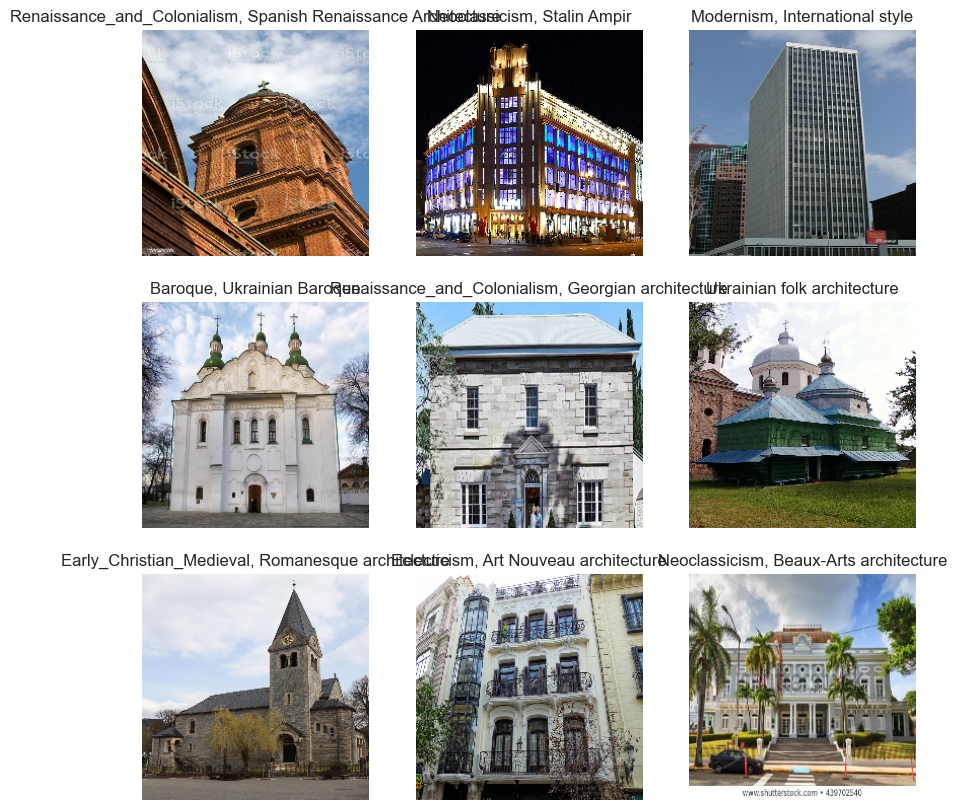

In [4]:
class_names = train_dataset.class_names
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        label = labels[i].numpy().astype("int")
        plt.title(class_names[np.where(label == 1)[0][0]])
        plt.axis("off")

In [5]:
# class_labels = []
# for images, labels in train_dataset:
#     class_labels.extend(np.argmax(labels, axis=1))
# class_labels = np.array(class_labels)

In [6]:
# from sklearn.utils import compute_class_weight
# unique_labels = np.unique(class_labels)
# class_weights = compute_class_weight('balanced', classes=unique_labels, y=class_labels)
# class_weight_dict = dict(zip(unique_labels, class_weights))
# class_weight_dict

# 2 Preprocess and Augment Training Data

In [7]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)

In [8]:
data_augmentation = tf.keras.Sequential([])
data_augmentation.add(RandomFlip('horizontal'))
data_augmentation.add(RandomRotation(0.1))
data_augmentation.add(RandomZoom(0.2))
data_augmentation.add(RandomCrop(height=IMG_SIZE[0], width=IMG_SIZE[1]))
data_augmentation.add(RandomContrast(factor=0.2))

Augumented images

In [9]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.EfficientNetV2B0(input_shape=IMG_SHAPE,
                                                    include_top=True,
                                                    weights='imagenet')

In [10]:

preprocess_input = tf.keras.applications.efficientnet_v2.preprocess_input

# 3 Using EfficientNetB0V2

In [11]:
def arc_model(image_shape=IMG_SIZE):
    input_shape = image_shape + (3,)

    inputs = tf.keras.Input(shape=input_shape)
    x = data_augmentation(inputs)
    x = preprocess_input(x)

    base_model = tf.keras.applications.EfficientNetV2B0(input_tensor=x,
                                                        include_top=False,
                                                        weights='imagenet')
    base_model.trainable = False

    x = tf.keras.layers.GlobalAveragePooling2D(name="avg_pool")(base_model.output)
    x = tf.keras.layers.BatchNormalization()(x)
    
    top_dropout_rate = 0.2
    x = tf.keras.layers.Dropout(top_dropout_rate, name="top_dropout")(x)

    outputs = tf.keras.layers.Dense(51, activation='softmax')(x)
    model = tf.keras.Model(inputs, outputs)

    return model

In [12]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=2, verbose=1, min_lr=0.00001)
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=0, restore_best_weights=True)

In [13]:
model2 = arc_model(IMG_SIZE)
base_learning_rate = 0.001
model2.compile(optimizer=tf.keras.optimizers.Adam(),
               loss=tf.keras.losses.CategoricalFocalCrossentropy(),
               metrics=['accuracy'],
               )
initial_epochs = 50
history = model2.fit(train_dataset, validation_data=validation_dataset, epochs=initial_epochs, callbacks=[learning_rate_reduction, early_stopping])

Epoch 1/50
408/408 ━━━━━━━━━━━━━━━━━━━━ 421s 999ms/step - accuracy: 0.2399 - loss: 0.6995 - val_accuracy: 0.4672 - val_loss: 0.3913 - learning_rate: 0.0010
Epoch 2/50
408/408 ━━━━━━━━━━━━━━━━━━━━ 400s 968ms/step - accuracy: 0.4300 - loss: 0.4092 - val_accuracy: 0.5353 - val_loss: 0.3554 - learning_rate: 0.0010
Epoch 3/50
408/408 ━━━━━━━━━━━━━━━━━━━━ 401s 969ms/step - accuracy: 0.4685 - loss: 0.3576 - val_accuracy: 0.5393 - val_loss: 0.3409 - learning_rate: 0.0010
Epoch 4/50
408/408 ━━━━━━━━━━━━━━━━━━━━ 402s 972ms/step - accuracy: 0.4927 - loss: 0.3298 - val_accuracy: 0.5718 - val_loss: 0.3212 - learning_rate: 0.0010
Epoch 5/50
408/408 ━━━━━━━━━━━━━━━━━━━━ 402s 973ms/step - accuracy: 0.5089 - loss: 0.3129 - val_accuracy: 0.5684 - val_loss: 0.3202 - learning_rate: 0.0010
Epoch 6/50
408/408 ━━━━━━━━━━━━━━━━━━━━ 400s 967ms/step - accuracy: 0.5240 - loss: 0.2973 - val_accuracy: 0.5988 - val_loss: 0.2885 - learning_rate: 0.0010
Epoch 7/50
408/408 ━━━━━━━━━━━━━━━━━━━━ 400s 967ms/step - accura

Results

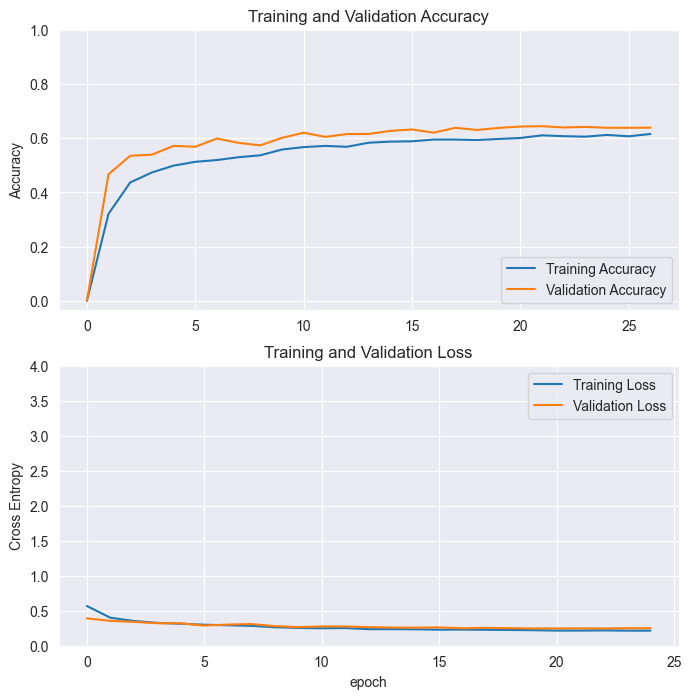

In [14]:
acc = [0.] + history.history['accuracy']
val_acc = [0.] + history.history['val_accuracy']

loss = history.history['loss'][:25]
val_loss = history.history['val_loss'][:25]
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()), 1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0, 4.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [15]:
from tensorflow.keras import layers

for layer in model2.layers[-20:]:
    if not isinstance(layer, layers.BatchNormalization):
        layer.trainable = True
loss_function = tf.keras.losses.CategoricalFocalCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.1 * base_learning_rate)
metrics = ['accuracy']

model2.compile(loss=loss_function,
               optimizer=optimizer,
               metrics=metrics)

fine_tune_epochs = 50
total_epochs = initial_epochs + fine_tune_epochs

history_fine = model2.fit(train_dataset,
                          epochs=total_epochs,
                          initial_epoch=history.epoch[-1],
                          validation_data=validation_dataset,
                          callbacks=[learning_rate_reduction, early_stopping],
                          )

Epoch 26/100
408/408 ━━━━━━━━━━━━━━━━━━━━ 424s 992ms/step - accuracy: 0.6134 - loss: 0.2150 - val_accuracy: 0.6495 - val_loss: 0.2430 - learning_rate: 1.0000e-04
Epoch 27/100
408/408 ━━━━━━━━━━━━━━━━━━━━ 406s 982ms/step - accuracy: 0.6208 - loss: 0.2047 - val_accuracy: 0.6621 - val_loss: 0.2297 - learning_rate: 1.0000e-04
Epoch 28/100
408/408 ━━━━━━━━━━━━━━━━━━━━ 405s 979ms/step - accuracy: 0.6285 - loss: 0.1958 - val_accuracy: 0.6673 - val_loss: 0.2276 - learning_rate: 1.0000e-04
Epoch 29/100
408/408 ━━━━━━━━━━━━━━━━━━━━ 405s 979ms/step - accuracy: 0.6433 - loss: 0.1962 - val_accuracy: 0.6621 - val_loss: 0.2272 - learning_rate: 1.0000e-04
Epoch 30/100
408/408 ━━━━━━━━━━━━━━━━━━━━ 0s 813ms/step - accuracy: 0.6478 - loss: 0.1852
Epoch 30: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
408/408 ━━━━━━━━━━━━━━━━━━━━ 407s 984ms/step - accuracy: 0.6478 - loss: 0.1852 - val_accuracy: 0.6633 - val_loss: 0.2253 - learning_rate: 1.0000e-04
Epoch 31/100
408/408 ━━━━━━━━━━━━━━━

Results

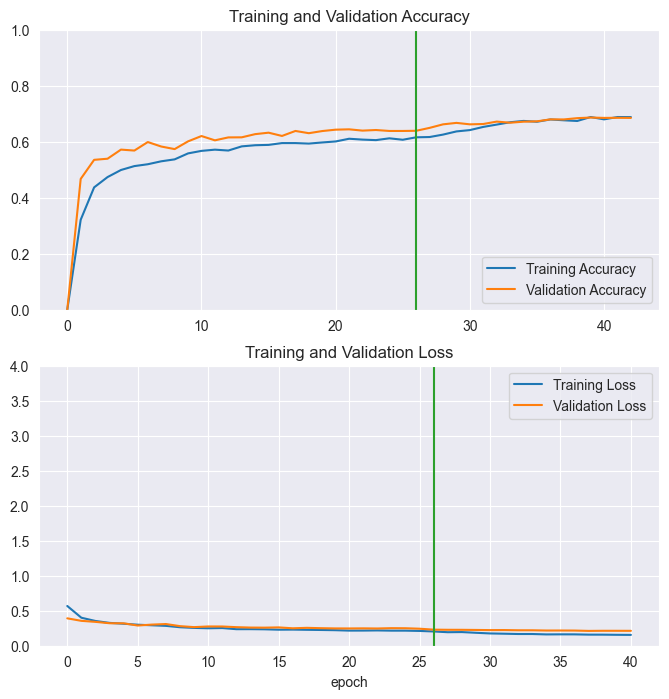

In [16]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1])
plt.plot([26, 26],
         plt.ylim())
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 4.0])
plt.plot([26, 26],
         plt.ylim())
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# Evaluate the results

In [19]:
test_directory = 'D:/University/FinalDatasetSplited/test'
test_dataset = tf.keras.utils.image_dataset_from_directory(test_directory,
                                                            shuffle=False,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE,
                                                            label_mode='categorical',
                                                            seed=42)
test_dataset = test_dataset.map(lambda x, y: (preprocess_input(x), y))

Found 1808 files belonging to 51 classes.


In [18]:
loss, accuracy = model2.evaluate(train_dataset, batch_size=BATCH_SIZE, verbose=0)
print('Train Loss:', loss, 'Train Accuracy:', accuracy)

Train Loss: 0.123550646007061 Train Accuracy: 0.7317784428596497


In [20]:
loss, accuracy = model2.evaluate(validation_dataset, batch_size=BATCH_SIZE, verbose=0)
print('Validation Loss:', loss, 'Validation Accuracy:', accuracy)

Validation Loss: 0.21178558468818665 Validation Accuracy: 0.6863106489181519


In [21]:
loss, accuracy = model2.evaluate(test_dataset, batch_size=BATCH_SIZE, verbose=0)
print('Test Loss:', loss, 'Test Accuracy:', accuracy)

Test Loss: 0.2846258282661438 Test Accuracy: 0.5779867172241211


In [22]:
from sklearn.metrics import classification_report

prediction = model2.predict(test_dataset, batch_size=BATCH_SIZE, verbose=1)

57/57 ━━━━━━━━━━━━━━━━━━━━ 35s 574ms/step


In [23]:
true_labels = []
for images, labels in test_dataset:
    true_labels.extend(np.argmax(labels, axis=1))

predicted_labels = np.argmax(prediction, axis=1)

print(classification_report(true_labels, predicted_labels, target_names=class_names))

                                                                precision    recall  f1-score   support

                                   21_st_Century, Blobitecture       0.59      0.74      0.65        23
                               21_st_Century, Deconstructivism       0.66      0.62      0.64        34
                               21_st_Century, Eco-architecture       0.93      0.56      0.70        25
                      21_st_Century, Neo-futurism architecture       0.57      0.36      0.44        11
                        21_st_Century, Postmodern architecture       0.82      0.44      0.57        32
                          Baroque, Andean Baroque Architecture       0.42      0.42      0.42        12
                                 Baroque, Baroque architecture       0.46      0.59      0.51        46
                      Baroque, Earthquake Baroque Architecture       0.00      0.00      0.00        13
                                  Baroque, Rococo Architecture 

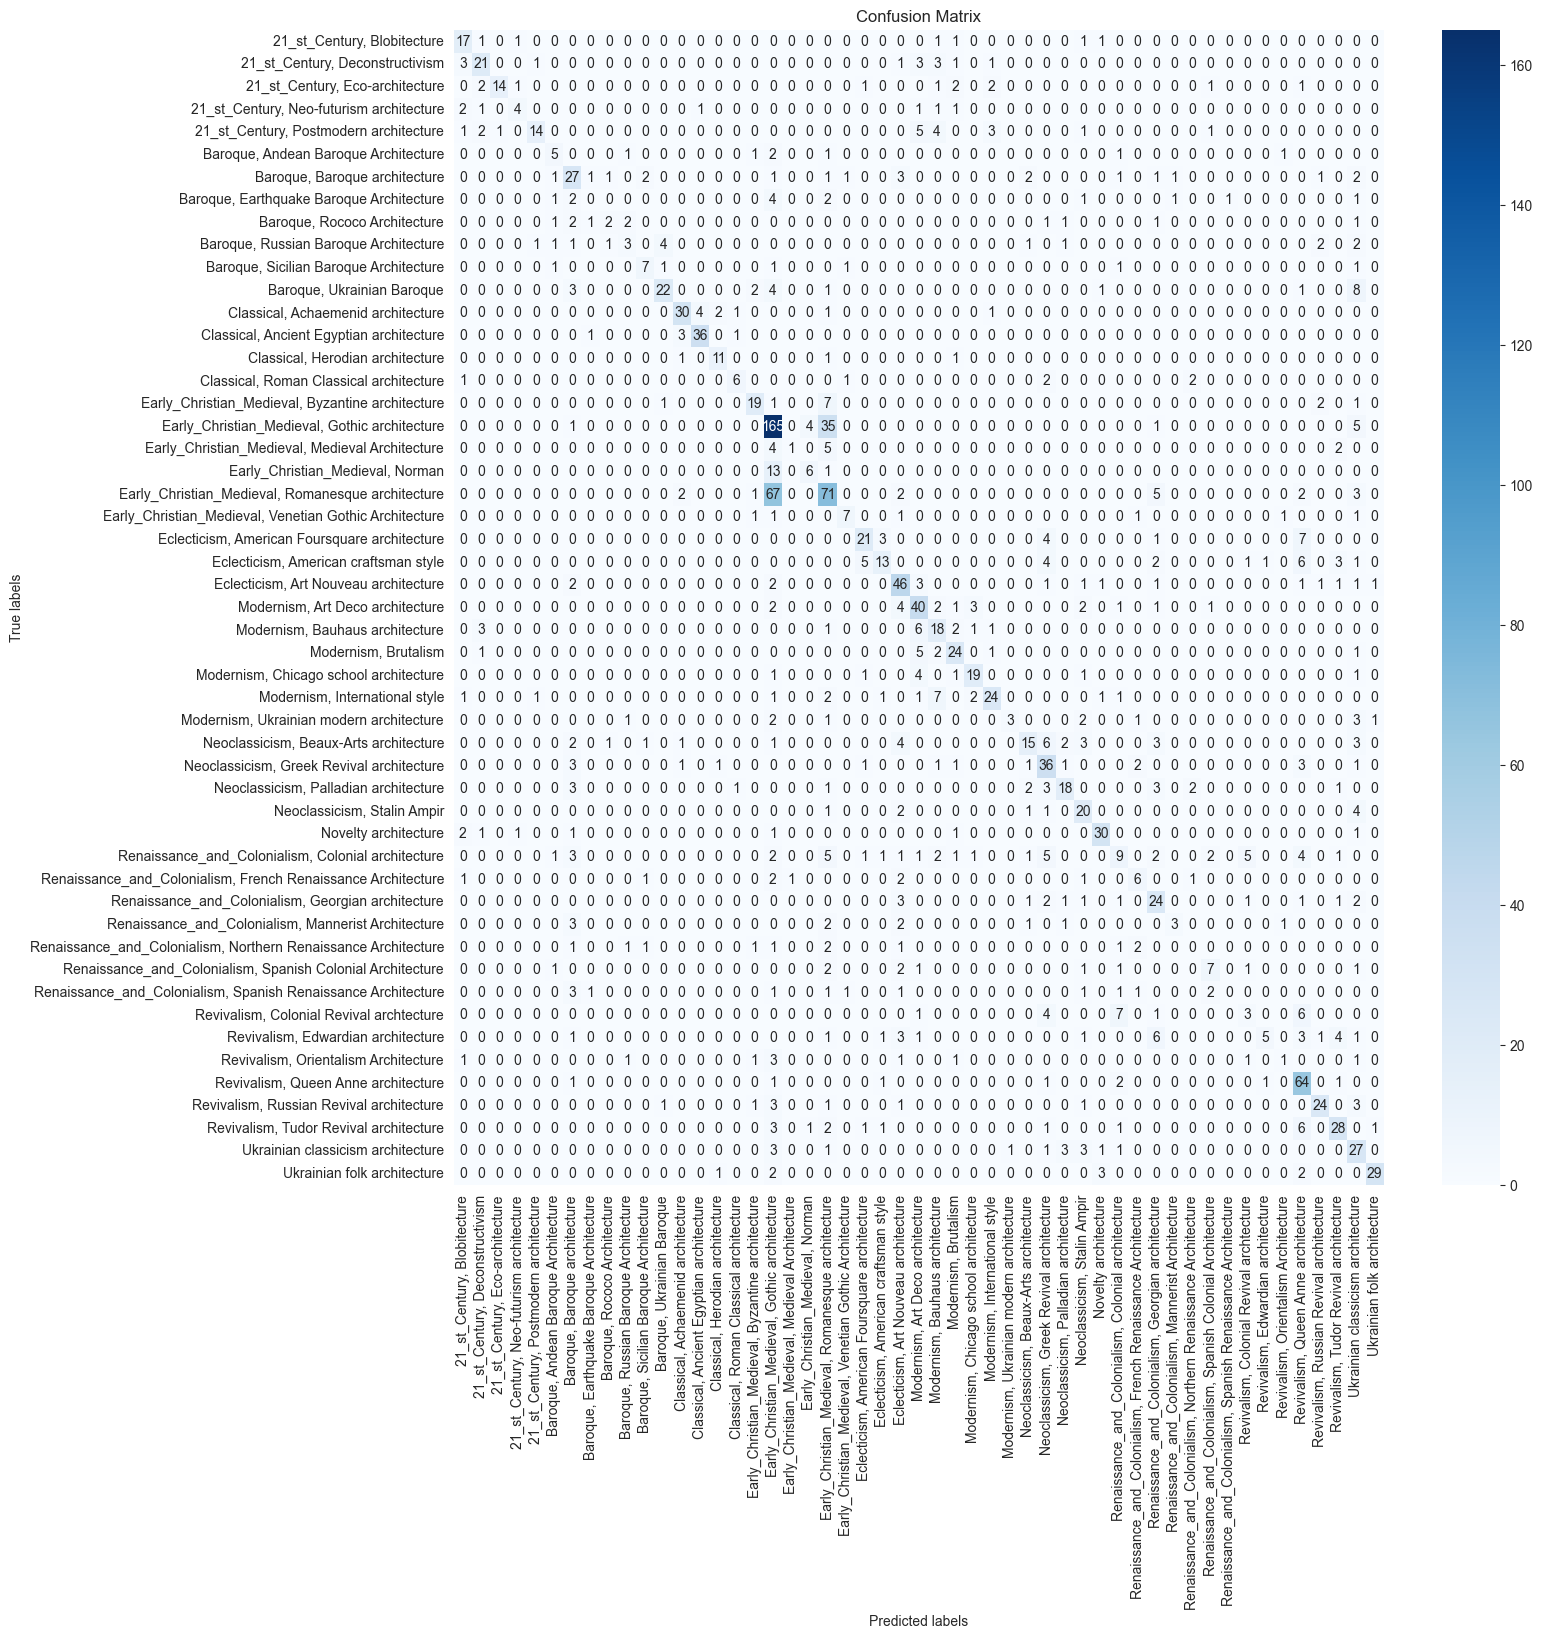

In [24]:
conf_matrix = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(15, 15))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [27]:
model_name = "model_focal_weighted_v1"
model_json = model2.to_json()
with open(f"{model_name}_architecture.json", "w") as json_file:
    json_file.write(model_json)

# Save the model weights to HDF5 file
model2.save_weights(f"{model_name}.weights.h5")

In [29]:

tf.keras.models.save_model(model2, f"{model_name}.keras")

In [30]:
converter = tf.lite.TFLiteConverter.from_keras_model(model2)
tflite_model = converter.convert()

# Save the TFLite model to a file
with open('models/model_focal_weighted_v1.tflite', 'wb') as f:
    f.write(tflite_model)

AttributeError: 'Functional' object has no attribute '_get_save_spec'

In [31]:
for epoch, history in enumerate(acc):
    task.get_logger().report_scalar("training", "accuracy", history, iteration=epoch)
for epoch, history in enumerate(val_loss):
    task.get_logger().report_scalar("validation", "loss", history, iteration=epoch)
for epoch, history in enumerate(val_acc):
    task.get_logger().report_scalar("validation", "accuracy", history, iteration=epoch)

In [32]:
task.upload_artifact(artifact_object="model_focal_weighted_v1.keras", name="focal")

True

In [33]:
task.upload_artifact(artifact_object="model_focal_weighted_v1_architecture.json", name="focal_architecture")

True

In [34]:
task.upload_artifact(artifact_object="model_focal_weighted_v1.weights.h5", name="focal_weights")

True